In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [4]:
# Configure plot style
plt.style.use('seaborn-darkgrid' if 'seaborn-darkgrid' in plt.style.available else 'default')

In [5]:
AA_SCALES = {
    'Kyte-Doolittle Hydrophobicity': {
        'A': 1.8,  'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
        'L': 3.8,  'K': -3.9, 'M': 1.9,  'F': 2.8,  'P': -1.6,
        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
    },
    'Zimmerman Polarity': {
        'A': 8.1,  'R': 10.5, 'N': 11.6, 'D': 13.0, 'C': 5.5,
        'Q': 10.5, 'E': 12.3, 'G': 9.0,  'H': 10.4, 'I': 5.2,
        'L': 4.9,  'K': 11.3, 'M': 5.7,  'F': 5.2,  'P': 8.0,
        'S': 9.2,  'T': 8.6,  'W': 5.4,  'Y': 6.2,  'V': 5.9
    },
    'Bulkiness': {
        'A': 11.5,  'R': 14.28, 'N': 12.82, 'D': 11.68, 'C': 13.46,
        'Q': 14.45, 'E': 13.57, 'G': 3.4,   'H': 13.69, 'I': 21.40,
        'L': 21.40, 'K': 15.71, 'M': 16.25, 'F': 19.80, 'P': 17.43,
        'S': 9.47,  'T': 15.77, 'W': 21.67, 'Y': 18.03, 'V': 21.57
    },
    'Hopp-Woods Hydrophilicity': {
        'A': -0.5,  'R': 3.0,   'N': 0.2,  'D': 3.0,   'C': -1.0,
        'Q': 0.2,   'E': 3.0,   'G': 0.0,  'H': -0.5,  'I': -1.8,
        'L': -1.8,  'K': 3.0,   'M': -1.3, 'F': -2.5,  'P': 0.0,
        'S': 0.3,   'T': -0.4,  'W': -3.4, 'Y': -2.3,  'V': -1.5
    }
}

In [6]:
# =====================
# CORE FUNCTIONS
# =====================
def sequence_to_signal(seq: str, scale: dict) -> np.ndarray:
    """Convert protein sequence to numerical signal using specified scale."""
    return np.array([scale.get(aa, 0) for aa in seq])

def compute_dft(signal: np.ndarray) -> tuple:
    """Compute DFT and return frequency bins with magnitude spectrum."""
    n = len(signal)
    freq = np.fft.fftfreq(n, d=1)
    dft = np.fft.fft(signal)
    return freq[:n//2], np.abs(dft)[:n//2]

In [7]:
def count_consecutive_repeats_kmp(text, pattern):
    """
    Count the number of consecutive occurrences of 'pattern' at the beginning of 'text'.
    
    Although the consecutive matching can be done by simple slicing,
    this function mimics the efficiency of a KMP-based approach by leveraging Python's
    built-in string methods (which are implemented in C and are highly optimized).
    
    Parameters:
      text (str): The text to search.
      pattern (str): The pattern to match consecutively.
      
    Returns:
      int: The count of consecutive occurrences.
    """
    count = 0
    p = len(pattern)
    # Repeatedly check if 'text' starts with the pattern.
    while text.startswith(pattern):
        count += 1
        text = text[p:]
    return count

def detect_periodic_repeats(seq: str, scale: dict, 
                            min_period: int = 3, max_period: int = 20, 
                            threshold: float = 0.2) -> list:
    """
    Detect periodic repeats in a sequence using DFT-based analysis and a KMP-inspired
    approach for fast repeat detection.
    
    The process involves:
      1. Converting the sequence into a numerical signal.
      2. Computing its DFT to extract dominant frequencies.
      3. Converting significant frequencies (above a given threshold) to candidate periods.
      4. Scanning the sequence for regions where a substring of length 'period' repeats consecutively.
         For this, a KMP-style check (via efficient substring matching) is used.
      5. Overlap and containment checks are performed to avoid redundant detections.
    
    Parameters:
      seq (str): Input sequence.
      scale (dict): Descriptor scale to convert sequence to a numerical signal.
      min_period (int): Minimum period (length of repeat unit) to consider.
      max_period (int): Maximum period to consider.
      threshold (float): Fraction of the maximum magnitude for selecting significant DFT peaks.
      
    Returns:
      list: A sorted list of detected repeats, each represented as a dictionary with details.
    """
    # Step 1: Convert sequence to a numerical signal and compute its DFT.
    signal = sequence_to_signal(seq, scale)
    freq, magnitude = compute_dft(signal)
    
    # Step 2: Exclude the zero frequency to avoid division by zero.
    non_zero_mask = freq != 0
    periods_array = 1 / freq[non_zero_mask]
    
    # Step 3: Filter for candidate periods within the desired range.
    valid_periods = (periods_array >= min_period) & (periods_array <= max_period)
    valid = np.zeros_like(freq, dtype=bool)
    valid[non_zero_mask] = valid_periods
    
    # Identify significant peaks in the magnitude spectrum.
    candidate_freq = freq[valid]
    candidate_mag = magnitude[valid]
    if candidate_mag.size > 0:
        peaks = candidate_freq[candidate_mag > threshold * np.max(candidate_mag)]
    else:
        peaks = np.array([])
    
    # Convert the significant peaks to candidate periods (rounded to the nearest integer).
    candidate_periods = (np.unique(np.round(1 / np.abs(peaks)).astype(int))
                         if peaks.size > 0 else np.array([]))
    
    repeats = []
    covered_intervals = []  # To track regions already assigned as repeats.
    
    # Step 4: For each candidate period (processed in descending order of period),
    # scan the sequence for consecutive repeats.
    for period in sorted(candidate_periods, key=lambda p: -p):
        if not (min_period <= period <= max_period):
            continue
            
        # Slide through the sequence with step size 1.
        for i in range(len(seq) - period * 2 + 1):
            # Skip positions already covered by previously detected repeats.
            if any(start <= i < end for start, end in covered_intervals):
                continue
            
            pattern = seq[i:i+period]
            # Use the KMP-inspired function to count consecutive occurrences of 'pattern'
            # starting from position i.
            count = count_consecutive_repeats_kmp(seq[i:], pattern)
            
            # Consider as a valid repeat if the pattern is repeated at least twice.
            if count >= 2:
                end_pos = i + period * count
                # Check for overlap with previously recorded intervals.
                if any(not (end_pos <= start or i >= end) for start, end in covered_intervals):
                    continue
                
                repeats.append({
                    'period': period,
                    'start': i,
                    'end': end_pos,
                    'segment': pattern,
                    'count': count,
                    'length': period * count
                })
                covered_intervals.append((i, end_pos))
    
    # Step 5: Filter out repeats that are entirely contained within a larger repeat.
    final_repeats = []
    for rep in sorted(repeats, key=lambda x: (x['start'], -x['length'])):
        if not any(r['start'] <= rep['start'] and rep['end'] <= r['end'] for r in final_repeats):
            final_repeats.append(rep)
    
    return sorted(final_repeats, key=lambda x: x['start'])

In [8]:
# =====================
# VISUALIZATION ENGINE
# =====================
def plot_analysis(seq: str, scale: dict, scale_name: str):
    """Generate integrated visualization of sequence analysis."""
    # Compute analysis components
    signal = sequence_to_signal(seq, scale)
    freq, magnitude = compute_dft(signal)
    repeats = detect_periodic_repeats(seq, scale)
    
    # Create figure with constrained layout
    fig = plt.figure(figsize=(14, 12), facecolor='#f5f5f5')
    gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 0.8])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    
    # Custom color scheme
    colors = ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c']
    cmap = LinearSegmentedColormap.from_list("spectral", colors, N=256)
    
    # Plot 1: Amino Acid Signal
    ax1.plot(signal, lw=2, color='#2c7bb6', marker='o', markersize=6,
            markerfacecolor='white', markeredgewidth=1.5)
    ax1.set_title(f"Amino Acid Signal: {scale_name}", fontsize=14, pad=12)
    ax1.set_xlabel("Residue Position", fontsize=10)
    ax1.set_ylabel("Scale Value", fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: DFT Spectrum
    periods = 1/freq[freq != 0]
    mag = magnitude[freq != 0]
    ax2.semilogy(periods, mag, color='#d7191c', lw=2)
    ax2.set_title("Frequency Spectrum Analysis", fontsize=14, pad=12)
    ax2.set_xlabel("Period (residues)", fontsize=10)
    ax2.set_ylabel("Magnitude (log scale)", fontsize=10)
    ax2.set_xlim(0, 20)
    ax2.grid(True, which='both', alpha=0.3)
    
    # Highlight significant periods
    for rep in repeats:
        ax2.axvline(rep['period'], color='#2c7bb6', linestyle='--', alpha=0.7)
    
    # Plot 3: Sequence Visualization
    ax3.set_xlim(0, len(seq))
    ax3.set_ylim(0, 1)
    ax3.axis('off')
    
    # Create sequence text elements
    for i, aa in enumerate(seq):
        ax3.text(i + 0.5, 0.5, aa, ha='center', va='center',
                fontsize=12, fontfamily='monospace', 
                color='#2c7bb6', weight='bold')
    
    # Add repeat highlights
    for rep in repeats:
        ax3.axvspan(rep['start'], rep['end'], color='#abd9e9', alpha=0.4)
        ax3.text(rep['start'] + rep['length']/2, 0.8, 
                f"{rep['segment']} x{rep['count']}",
                ha='center', va='center', color='#2c7bb6',
                fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Console output
    print(f"\n{scale_name} Analysis:")
    print(f"Found {len(repeats)} significant repeats")
    for rep in sorted(repeats, key=lambda x: x['start']):
        print(f" • {rep['segment']} repeated {rep['count']}x "
              f"(positions {rep['start']}-{rep['end']-1})")

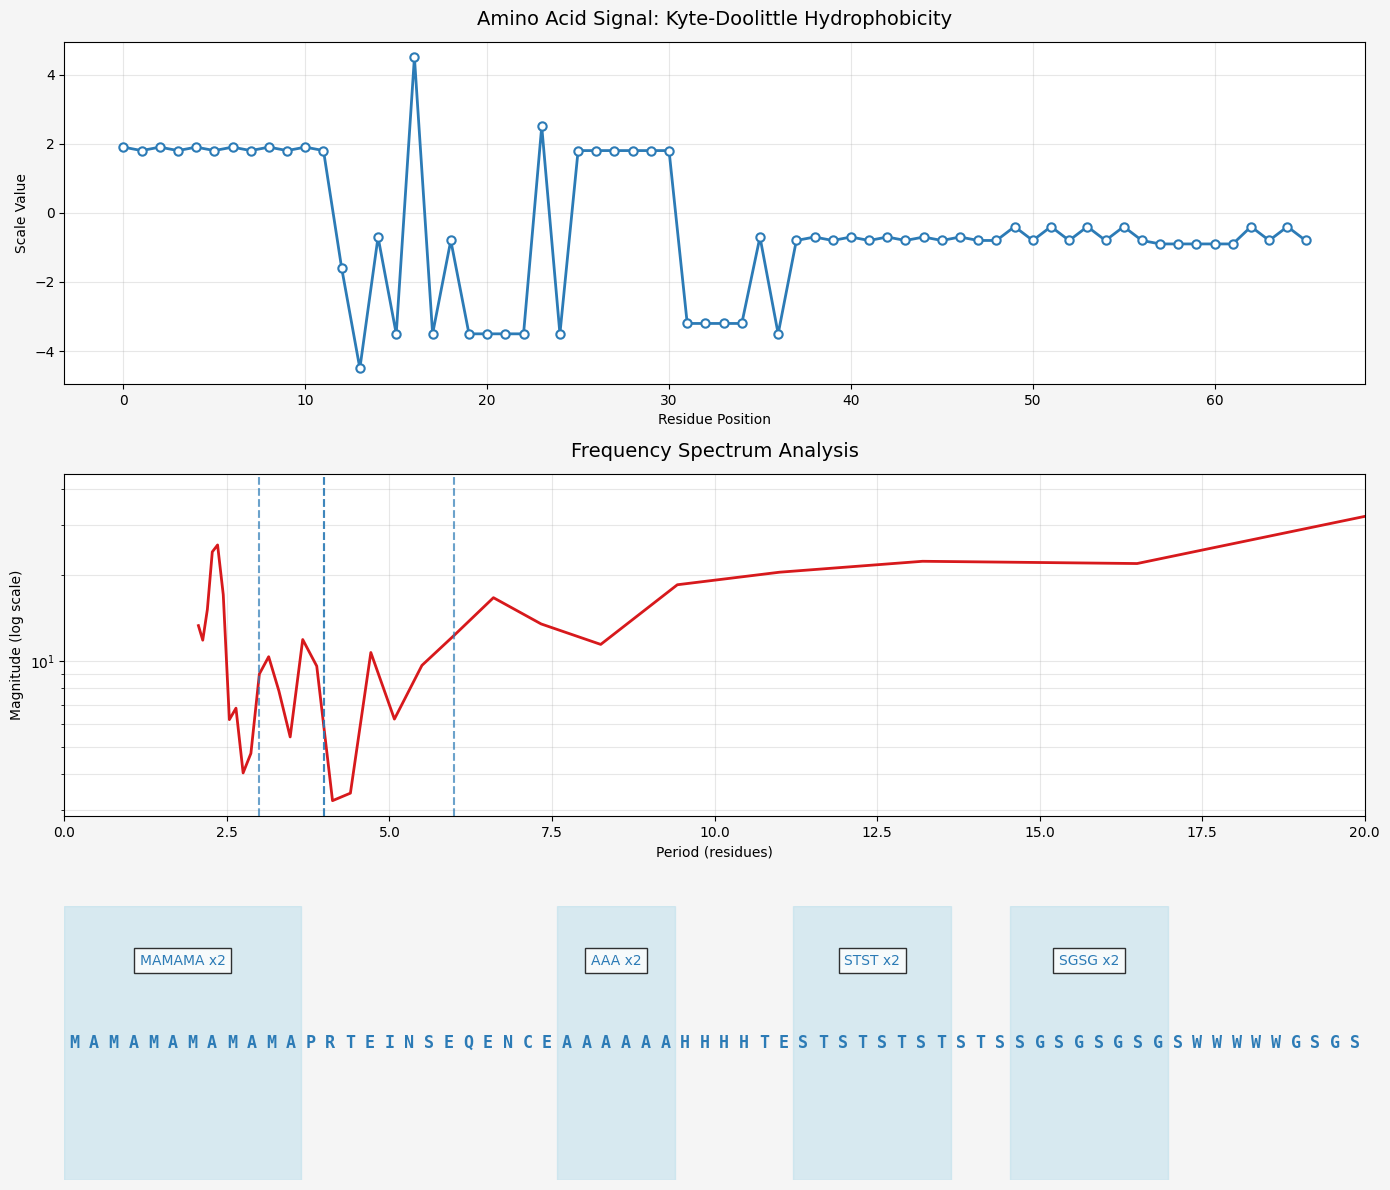


Kyte-Doolittle Hydrophobicity Analysis:
Found 4 significant repeats
 • MAMAMA repeated 2x (positions 0-11)
 • AAA repeated 2x (positions 25-30)
 • STST repeated 2x (positions 37-44)
 • SGSG repeated 2x (positions 48-55)


In [9]:
# =====================
# EXAMPLE USAGE
# =====================
test_sequence = "MAMAMAMAMAMAPRTEINSEQENCEAAAAAAHHHHTESTSTSTSTSTSSGSGSGSGSWWWWWGSGS"

plot_analysis(test_sequence, AA_SCALES['Kyte-Doolittle Hydrophobicity'], 'Kyte-Doolittle Hydrophobicity')
# plot_analysis(test_sequence, AA_SCALES['Zimmerman Polarity'], 'Zimmerman Polarity')
# plot_analysis(test_sequence, AA_SCALES['Bulkiness'], 'Bulkiness')
# plot_analysis(test_sequence, AA_SCALES['Hopp-Woods Hydrophilicity'], 'Hopp-Woods Hydrophilicity')